# RascalMCES score computations

Compute rascalMCES scores using rdkit for a sub-sample of the data. This is later used to measure the correlation between MCES-scores and different fingerprint-based molecular similarities.

## Data

We here use the **biostructures dataset** containing 730,464 unique compounds.

In [ ]:
import os
from pathlib import Path
import pickle
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm

from rdkit.Chem import rdRascalMCES, MolFromSmiles

ROOT = Path(os.getcwd()).parents[0]
path_data = os.path.join(Path(ROOT), "data")

In [3]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [4]:
compounds.shape

(37811, 10)

# For comparison: rascalMCES

## Problem: Computationally MUCH more expensive than fingerprint-based scores

--> Sub-sample:
- Only pick pairs with mass difference <= `mass_difference`
- Pick `N` pairs per compounds

In [ ]:
def create_pairs(
    selected_compounds: pd.DataFrame,
    previous_pairs: pd.DataFrame = None,
    N: int = 10,
    mass_diff_min: float = 0,
    mass_diff_max: float = 100,
    seed: int = 42
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)

    # Sort by mass and keep original indices
    sorted_comp = (
        selected_compounds
        .reset_index(drop=False)
        .rename(columns={"index": "orig_idx"})
        .sort_values("mass")
        .reset_index(drop=True)
    )

    masses   = sorted_comp["mass"].values
    inchis   = sorted_comp["inchikey"].values
    smiles   = sorted_comp["smiles"].values
    orig_ids = sorted_comp["orig_idx"].values
    n        = len(sorted_comp)

    # Build initial set of forbidden (unordered) pairs
    prev_set = set()
    if previous_pairs is not None:
        prev_set = {
            frozenset((r["inchikey1"], r["inchikey2"]))
            for _, r in previous_pairs.iterrows()
        }

    pairs = []
    for i in range(n):
        mi, key_i, smi, orig_i = masses[i], inchis[i], smiles[i], orig_ids[i]
        
        # find all candidates within the mass window
        diffs = np.abs(masses - mi)
        mask  = (diffs >= mass_diff_min) & (diffs <= mass_diff_max)
        mask[i] = False  # never pair with itself
        idxs = np.nonzero(mask)[0]
        
        # drop any that would re‐create an existing or newly created pair
        filtered = []
        for j in idxs:
            if j <= i:
                # skip j<=i to enforce i<j ordering
                continue
            if frozenset((key_i, inchis[j])) in prev_set:
                # skip if already in previous or newly added set
                continue
            filtered.append(j)

        if not filtered:
            continue

        # sample up to N of the remaining
        chosen = rng.choice(filtered, size=min(N, len(filtered)), replace=False)
        for j in chosen:
            _, smj, orig_j, key_j = masses[j], smiles[j], orig_ids[j], inchis[j]
            pairs.append({
                "index1": orig_i,    "index2": orig_j,
                "smiles1": smi,      "smiles2": smj,
                "mass_difference": diffs[j],
                "inchikey1": key_i,  "inchikey2": key_j
            })
            # immediately record it so we won’t duplicate later
            prev_set.add(frozenset((key_i, key_j)))

    return pd.DataFrame(pairs)


# Create further pairs

## Compute Rascal scores (in parallel with checkpoints)
- Do not use the full number of cores! (will crash eventually --> better: about 50%-75%)

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')


def compute_mces_for_pair_safe(row, opts):
    """
    Safely compute the MCES score for a single pair.
    """
    try:
        mol1 = MolFromSmiles(row["smiles1"])
        mol2 = MolFromSmiles(row["smiles2"])
    except Exception as e:
        logging.error(f"Error in molecule preparation: {e}")
        return 0.0, True

    try:
        results = rdRascalMCES.FindMCES(mol1, mol2, opts)
        if results:
            similarity = results[0].similarity
            timeout_occurred = results[0].timedOut
            return similarity, timeout_occurred
        else:
            return 0.0, False
    except Exception as e:
        logging.error(f"Error in FindMCES: {e}")
        return 0.0, True


def init_worker(options):
    """
    Initialize worker process with shared options.
    """
    global opts
    opts = options


def worker_compute_mces(row):
    """
    Compute MCES score for a single pair. Uses the global 'opts'
    set in the worker initializer.
    """
    try:
        return compute_mces_for_pair_safe(row, opts)
    except Exception as e:
        logging.error(f"Error in worker_compute_mces: {e}")
        return 0.0, True


def worker_compute_mces_with_index(pair):
    """
    Worker function that takes a tuple (index, row), computes the MCES result,
    and returns a tuple (index, result).
    """
    idx, row = pair
    result = worker_compute_mces(row)
    return idx, result


def compute_rascal_MCES_scores_parallel(pairs_df):
    """
    Simple (non-checkpointing) parallel computation of MCES scores
    using multiprocessing.Pool.
    """
    # Set up RascalOptions
    options = rdRascalMCES.RascalOptions()
    options.similarityThreshold = 0.05
    options.returnEmptyMCES = False
    options.singleLargestFrag = True
    options.allBestMCESs = False
    options.maxBondMatchPairs = 10000
    options.completeAromaticRings = False
    options.timeout = 60
    options.minFragSize = 3

    rows = [row for _, row in pairs_df.iterrows()]

    with multiprocessing.Pool(initializer=init_worker, initargs=(options,)) as pool:
        results = list(tqdm(pool.imap(worker_compute_mces, rows),
                            total=len(rows),
                            desc="Processing MCES pairs"))
    if results:
        scores, timeouts = zip(*results)
        return np.array(scores), np.array(timeouts)
    else:
        return np.array([]), np.array([])


def compute_rascal_MCES_scores_parallel_with_checkpoint(
    pairs_df,
    checkpoint_file="checkpoint.pkl",
    resume=True,
    checkpoint_interval=100,
    max_retries=5,
    progress_bar=False,
    num_workers=None  # if None, uses os.cpu_count()
):
    """
    Parallelized computation of MCES scores with checkpointing using multiprocessing.Pool.
    
    If resume is True and a checkpoint file exists, previously computed results are loaded,
    and processing resumes from where it left off.
    
    Parameters:
      pairs_df: pandas DataFrame with at least columns "smiles1" and "smiles2".
      checkpoint_file: Path to the checkpoint file.
      resume: Whether to resume from an existing checkpoint.
      checkpoint_interval: Number of processed pairs between checkpoint saves.
      max_retries: Maximum number of times to retry if the pool crashes.
      num_workers: Number of worker processes (default: os.cpu_count()).
      
    Returns:
      Two numpy arrays: scores and timeout flags, ordered by the original DataFrame.
    """
    # Load checkpoint if available.
    if resume and os.path.exists(checkpoint_file):
        with open(checkpoint_file, "rb") as f:
            checkpoint_data = pickle.load(f)
        logging.info(f"Loaded checkpoint with {len(checkpoint_data)} processed pairs.")
    else:
        checkpoint_data = {}

    # Create a list of (index, row) pairs.
    all_rows = list(pairs_df.iterrows())

    retries = 0
    # Continue processing until all rows are done.
    while True:
        remaining_rows = [(idx, row) for idx, row in all_rows if idx not in checkpoint_data]
        total_remaining = len(remaining_rows)
        if total_remaining == 0:
            logging.info("All pairs have been processed.")
            break

        logging.info(f"{total_remaining} pairs remaining. Starting new pool (attempt {retries + 1}).")
        
        # Set up RascalOptions for this pool.
        options = rdRascalMCES.RascalOptions()
        options.similarityThreshold = 0.05
        options.returnEmptyMCES = False
        options.singleLargestFrag = True
        options.allBestMCESs = False
        options.maxBondMatchPairs = 10000
        options.completeAromaticRings = False
        options.timeout = 60
        options.minFragSize = 3

        try:
            with multiprocessing.Pool(initializer=init_worker, initargs=(options,), processes=num_workers) as pool:
                # Use imap_unordered to iterate over the results as they complete.
                for idx, result in tqdm(pool.imap_unordered(worker_compute_mces_with_index,
                                                              remaining_rows),
                                          total=total_remaining,
                                          desc="Processing with checkpoint",
                                        disable = (not progress_bar),
                                       ):
                    checkpoint_data[idx] = result
                    # Save checkpoint periodically.
                    if (len(checkpoint_data) % checkpoint_interval) == 0:
                        with open(checkpoint_file, "wb") as f:
                            pickle.dump(checkpoint_data, f)
                        logging.info(f"Checkpoint saved: {len(checkpoint_data)} total pairs processed.")
            # If we reach here without exception, reset retries.
            retries = 0
        except Exception as e:
            retries += 1
            logging.error(f"Pool processing failed (attempt {retries}): {e}")
            with open(checkpoint_file, "wb") as f:
                pickle.dump(checkpoint_data, f)
            if retries >= max_retries:
                logging.critical("Maximum retry attempts reached. Exiting.")
                raise
            else:
                logging.info("Retrying processing for remaining tasks.")
                continue  # Retry processing the remaining tasks.

    # Final checkpoint save.
    with open(checkpoint_file, "wb") as f:
        pickle.dump(checkpoint_data, f)
    logging.info("Final checkpoint saved.")

    # Reconstruct results in the original DataFrame order.
    scores = []
    timeouts = []
    for idx, row in all_rows:
        if idx in checkpoint_data:
            s, t = checkpoint_data[idx]
        else:
            # This should not occur if all rows are processed.
            s, t = 0.0, True
        scores.append(s)
        timeouts.append(t)
    
    return np.array(scores), np.array(timeouts)


In [ ]:
"""
scores, timeouts = compute_rascal_MCES_scores_parallel_with_checkpoint(
    pairs2,
    checkpoint_file="rascal_checkpoint_250512.pkl",
    resume=True,
    checkpoint_interval=1000,
    num_workers=16,
)
"""

In [ ]:
#with open("rascal_checkpoint_250512.pkl", "rb") as file:
#    results = pickle.load(file)

In [93]:
def create_results_df(pairs, rascal_scores, compounds):
    idx = np.array(list(rascal_scores.keys()))
    values = np.array(list(rascal_scores.values()))
    idx1 = pairs.iloc[idx].index1
    idx2 = pairs.iloc[idx].index2

    inchikeys1 = compounds.iloc[idx1].inchikey.values
    inchikeys2 = compounds.iloc[idx2].inchikey.values

    mass_diff = np.abs(compounds.iloc[idx1].mass.values - compounds.iloc[idx2].mass.values)
    return pd.DataFrame({
        "inchikey1": inchikeys1,
        "inchikey2": inchikeys2,
        "mass_diff": mass_diff,
        "mass1": compounds.iloc[idx1].mass.values,
        "mass2": compounds.iloc[idx2].mass.values,
        "rascal": values[:, 0],
        "timeout": values[:, 1].astype(np.bool),
    }
    )

In [ ]:
#rascal_scores_new = create_results_df(pairs2, results, compounds)
#rascal_scores_new

# store in csv ...

## Inspect pairs

In [5]:
rascal_pairs = pd.read_csv(os.path.join(path_data, "rascal_benchmarking_set_250513.csv"))
rascal_pairs.head()

,inchikey1,inchikey2,mass_diff,mass1,mass2,rascal,timeout
0,AAAQFGUYHFJNHI,ACNHBCIZLNNLRS,12.09472,423.146204,435.240924,0.038877,False
1,AAAQFGUYHFJNHI,ACQNDKXMOBGYKN,83.05148,423.146204,340.094724,0.059829,False
2,AAAQFGUYHFJNHI,AHHKLTZSMVVPOJ,97.00092,423.146204,326.145284,0.082928,False
3,AAAQFGUYHFJNHI,AJJHWJZAMWDEKK,6.01142,423.146204,429.157624,0.136461,False
4,AAAQFGUYHFJNHI,AKEJXNSCRNEUTK,70.61000,423.904000,494.514000,0.102407,False


In [17]:
rascal_pairs.shape

(5557963, 8)

<Axes: >

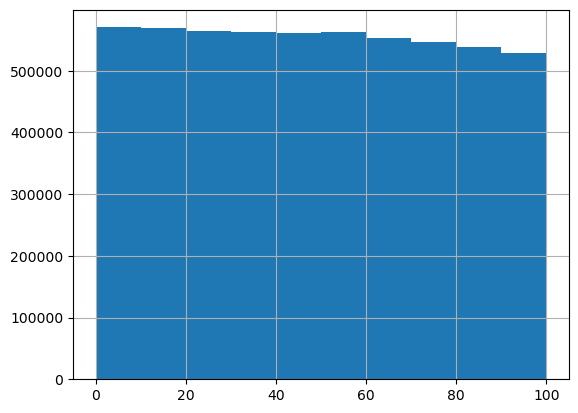

In [7]:
rascal_pairs.mass_diff.hist()

In [8]:
rascal_pairs.value_counts("timeout")

timeout
False    5413677
True      144286
Name: count, dtype: int64

<Axes: >

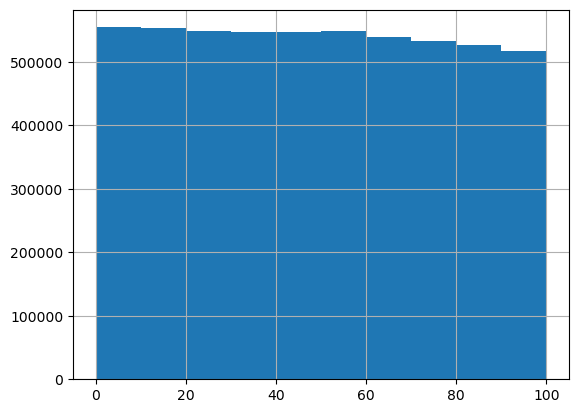

In [ ]:
mask = not rascal_pairs.timeout
rascal_pairs.mass_diff[mask].hist()

## Check Rascal Scores

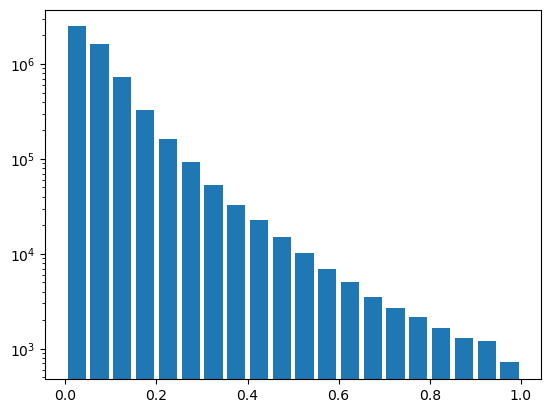

In [12]:
fig, ax = plt.subplots()

ax.hist(rascal_pairs.rascal, bins=20, rwidth=0.8)
ax.set_yscale("log")
plt.show()

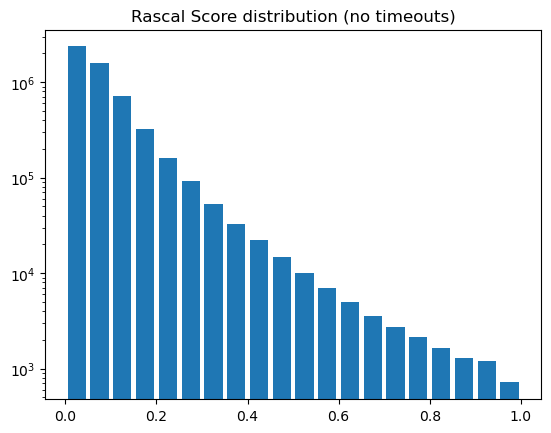

In [ ]:
mask = not rascal_pairs.timeout

fig, ax = plt.subplots()

ax.hist(rascal_pairs.rascal[mask], bins=20, rwidth=0.8)
ax.set_yscale("log")
ax.set_title("Rascal Score distribution (no timeouts)")
plt.show()

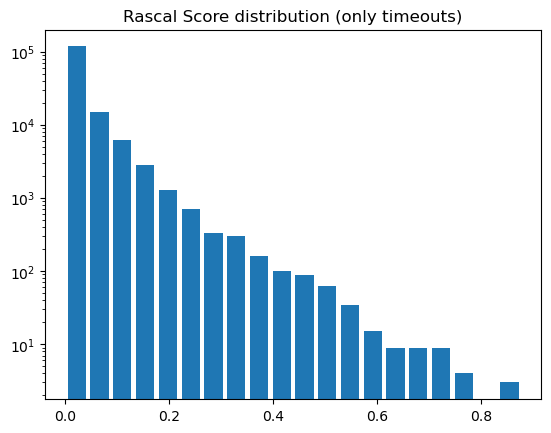

In [ ]:
mask = rascal_pairs.timeout

fig, ax = plt.subplots()

ax.hist(rascal_pairs.rascal[mask], bins=20, rwidth=0.8)
ax.set_yscale("log")
ax.set_title("Rascal Score distribution (only timeouts)")
plt.show()